In [1]:
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    MinMaxScaler,
    OrdinalEncoder,
    OneHotEncoder,
    PowerTransformer,
    QuantileTransformer,
)

# modelo referência
from sklearn.dummy import DummyRegressor

# modelos lineares
from sklearn.linear_model import Lasso, LinearRegression, Ridge

# modelos baseados em árvores de decisão
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# SVM
from sklearn.svm import LinearSVR

# kNN
from sklearn.neighbors import KNeighborsRegressor

# para exportar o modelo
from joblib import dump

from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_TRATADOS, MODELO_FINAL
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
    RANDOM_STATE,
)

/home/everson/anaconda3/envs/machine_learning/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
df = pd.read_parquet(DADOS_TRATADOS)

df.head()

,model_year,transmission,fuel_type,city_l_100_km,highway_l_100_km,combined_l_100_km,co2_emissions_g_km,vehicle_class_grouped,engine_size_l_class,cylinders_class
0,2005,A,reg_gasoline,9.2,7.2,8.3,191,car,up_to_2,up_to_4
1,2005,M,reg_gasoline,9.1,7.3,8.3,191,car,up_to_2,up_to_4
2,2005,A,premium_gasoline,15.9,11.1,13.7,315,suv,up_to_4,up_to_6
3,2005,AS,premium_gasoline,15.1,10.5,13.0,299,car,up_to_4,up_to_6
4,2005,M,premium_gasoline,15.1,10.5,13.0,299,car,up_to_4,up_to_6


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21169 entries, 0 to 21168
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   model_year             21169 non-null  int64   
 1   transmission           21169 non-null  object  
 2   fuel_type              21169 non-null  object  
 3   city_l_100_km          21169 non-null  float64 
 4   highway_l_100_km       21169 non-null  float64 
 5   combined_l_100_km      21169 non-null  float64 
 6   co2_emissions_g_km     21169 non-null  int64   
 7   vehicle_class_grouped  21169 non-null  object  
 8   engine_size_l_class    21169 non-null  category
 9   cylinders_class        21169 non-null  category
dtypes: category(2), float64(3), int64(2), object(3)
memory usage: 1.3+ MB


In [4]:
coluna_target = ["co2_emissions_g_km"]

colunas_ordinais = ["engine_size_l_class", "cylinders_class"]

colunas_ohe = ["transmission", "fuel_type", "vehicle_class_grouped"]

coluna_min_max = ["model_year"]

colunas_power_transform = ["city_l_100_km", "highway_l_100_km", "combined_l_100_km"]

In [5]:
preprocessamento = ColumnTransformer(
    transformers=[
        ("ordinal", OrdinalEncoder(categories="auto"), colunas_ordinais),
        ("onehot", OneHotEncoder(drop="first"), colunas_ohe),
        ("min_max", MinMaxScaler(), coluna_min_max),
        ("power_transform", PowerTransformer(), colunas_power_transform),
    ]
)

preprocessamento_arvore = ColumnTransformer(
    transformers=[
        ("ordinal", OrdinalEncoder(categories="auto"), colunas_ordinais),
        ("onehot", OneHotEncoder(drop="first"), colunas_ohe),
    ]
)

In [6]:
X = df.drop(columns=coluna_target)
y = df[coluna_target].values.reshape(-1)

In [7]:
regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    # modelos lineares
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": QuantileTransformer(output_distribution="normal"),
    },
    "Lasso": {
        "preprocessor": preprocessamento,
        "regressor": Lasso(),
        "target_transformer": QuantileTransformer(output_distribution="normal"),
    },
    "Ridge": {
        "preprocessor": preprocessamento,
        "regressor": Ridge(),
        "target_transformer": QuantileTransformer(output_distribution="normal"),
    },

    # modelos baseados em árvore
    "DecisionTreeRegressor": {
        "preprocessor": preprocessamento_arvore,
        "regressor": DecisionTreeRegressor(random_state=RANDOM_STATE),
        "target_transformer": None,
    },
    "LGBMRegressor": {
        "preprocessor": preprocessamento_arvore,
        "regressor": LGBMRegressor(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1,
        ),
        "target_transformer": None,
    },
    "XGBRegressor": {
        "preprocessor": preprocessamento_arvore,
        "regressor": XGBRegressor(
            random_state=RANDOM_STATE,
            n_jobs=-1,
        ),
        "target_transformer": None,
    },
    # SVM
    "LinearSVR": {
        "preprocessor": preprocessamento,
        "regressor": LinearSVR(max_iter=3000),
        "target_transformer": QuantileTransformer(output_distribution="normal"),
    },
    # kNN
    "KNeighborsRegressor": {
        "preprocessor": preprocessamento,
        "regressor": KNeighborsRegressor(n_jobs=-1),
        "target_transformer": QuantileTransformer(output_distribution="normal"),
    },
}


resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

/home/everson/anaconda3/envs/machine_learning/lib/python3.12/site-packages/sklearn/compose/_target.py:196: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn(
/home/everson/anaconda3/envs/machine_learning/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/everson/anaconda3/envs/machine_learning/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/everson/anaconda3/envs/machine_learning/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.007552,0.003521,-0.000494,-49.71469,-63.300741,0.011073
1,DummyRegressor,0.004757,0.002991,-0.000052,-50.138646,-63.313486,0.007748
2,DummyRegressor,0.004014,0.002211,-0.000018,-50.023903,-63.762463,0.006225
3,DummyRegressor,0.003611,0.003056,-0.000108,-50.139548,-63.515391,0.006666
4,DummyRegressor,0.003546,0.002196,-0.000077,-50.636052,-64.102928,0.005742
5,LinearRegression,0.279115,0.033888,0.996441,-2.472668,-3.775511,0.313003
6,LinearRegression,0.25852,0.023477,0.995633,-2.71175,-4.184069,0.281996
7,LinearRegression,0.187435,0.025366,0.996111,-2.526,-3.976083,0.212801
8,LinearRegression,0.212663,0.034042,0.996765,-2.392317,-3.612228,0.246705
9,LinearRegression,0.2795,0.024967,0.99569,-2.624631,-4.208275,0.304467


In [8]:
df_resultados.groupby("model").mean().sort_values(by="test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
Lasso,0.236523,0.024691,-0.006924,-49.930998,-63.813693,0.261214
DummyRegressor,0.004696,0.002795,-0.00015,-50.130568,-63.599002,0.007491
LGBMRegressor,1.029279,0.067253,0.824376,-20.02821,-26.648524,1.096532
XGBRegressor,0.691666,0.072976,0.826973,-19.83322,-26.451987,0.764642
DecisionTreeRegressor,0.093257,0.017954,0.826997,-19.82036,-26.450169,0.111212
Ridge,0.18975,0.026164,0.996125,-2.540684,-3.955285,0.215914
LinearRegression,0.243447,0.028348,0.996128,-2.545473,-3.951233,0.271795
KNeighborsRegressor,0.245792,0.575061,0.996241,-2.025657,-3.895432,0.820854
LinearSVR,5.737827,0.025998,0.996279,-2.234503,-3.871334,5.763825


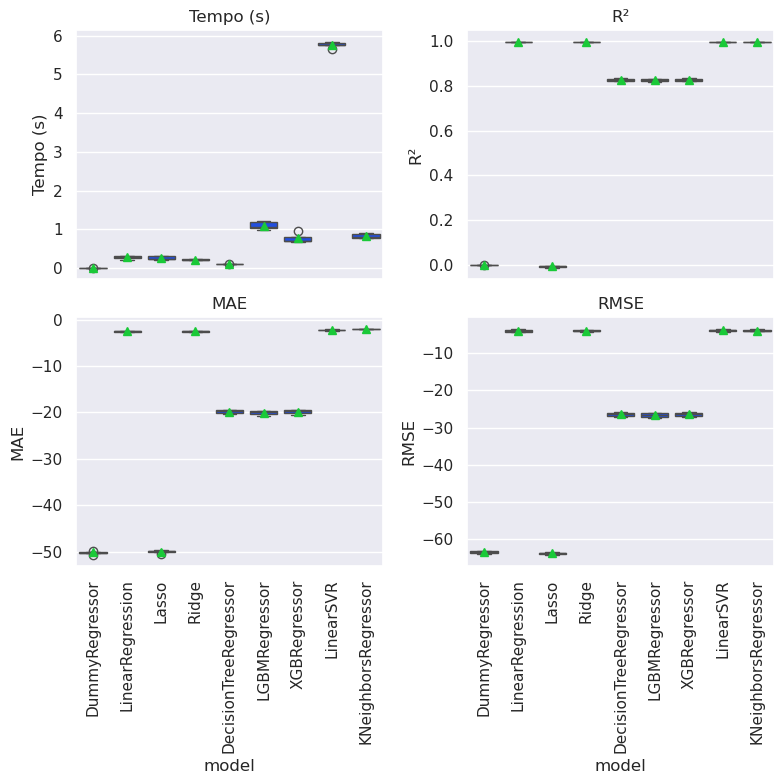

In [9]:
plot_comparar_metricas_modelos(df_resultados)

In [10]:
param_grid = {
    "regressor__reg__alpha": [0.1, 0.5, 1, 2, 5, 10]
}

In [11]:
grid_search = grid_search_cv_regressor(
    regressor=Ridge(),
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution="normal"),
    param_grid=param_grid,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['engine_size_l_class',
                                                                                                               'cylinders_class']),
                                                                                                             ('onehot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['transmission',
                                                                                                               'fuel_type',
                                                                                                               'vehicle_class_grouped']),
                                                                                                             ('min_max',
                                                                                                              Mi...
                                                                                                             ('power_transform',
                                                                                                              PowerTransformer(),
                                                                                                              ['city_l_100_km',
                                                                                                               'highway_l_100_km',
                                                                                                               'combined_l_100_km'])])),
                                                                            ('reg',
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__reg__alpha': [0.1, 0.5, 1, 2, 5, 10]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [12]:
grid_search.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['engine_size_l_class',
                                                                                                               'cylinders_class']),
                                                                                                             ('onehot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['transmission',
                                                                                                               'fuel_type',
                                                                                                               'vehicle_class_grouped']),
                                                                                                             ('min_max',
                                                                                                              Mi...
                                                                                                             ('power_transform',
                                                                                                              PowerTransformer(),
                                                                                                              ['city_l_100_km',
                                                                                                               'highway_l_100_km',
                                                                                                               'combined_l_100_km'])])),
                                                                            ('reg',
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__reg__alpha': [0.1, 0.5, 1, 2, 5, 10]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [13]:
grid_search.best_params_

{'regressor__reg__alpha': 1}

In [14]:
grid_search.best_score_

-3.7515955828567895

In [15]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out(),
)

coefs

,coeficiente
onehot__fuel_type_ethanol,-2.118052
onehot__fuel_type_premium_gasoline,-0.609647
onehot__fuel_type_reg_gasoline,-0.597142
onehot__vehicle_class_grouped_special_purpose,-0.033455
onehot__vehicle_class_grouped_suv,-0.019931
onehot__transmission_M,-0.010075
onehot__vehicle_class_grouped_station_wagon,-0.007978
onehot__vehicle_class_grouped_pickup_truck,-0.007557
onehot__transmission_AS,-0.004886
ordinal__engine_size_l_class,-0.002040


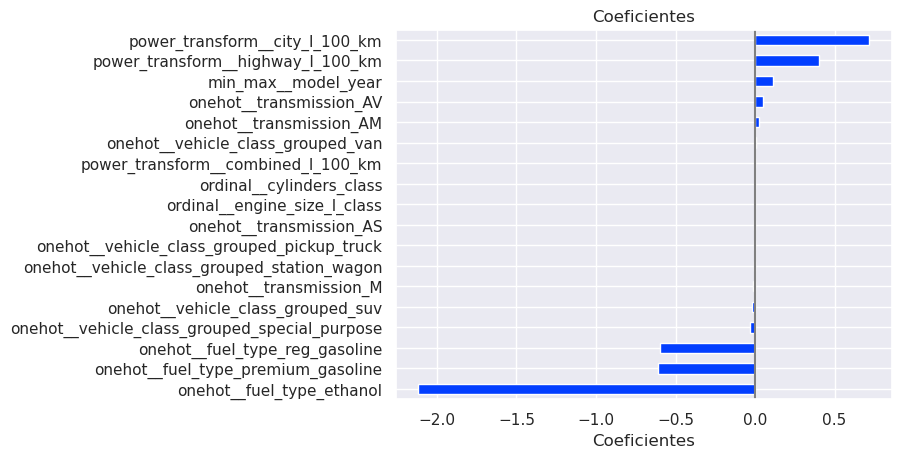

In [16]:
plot_coeficientes(coefs)

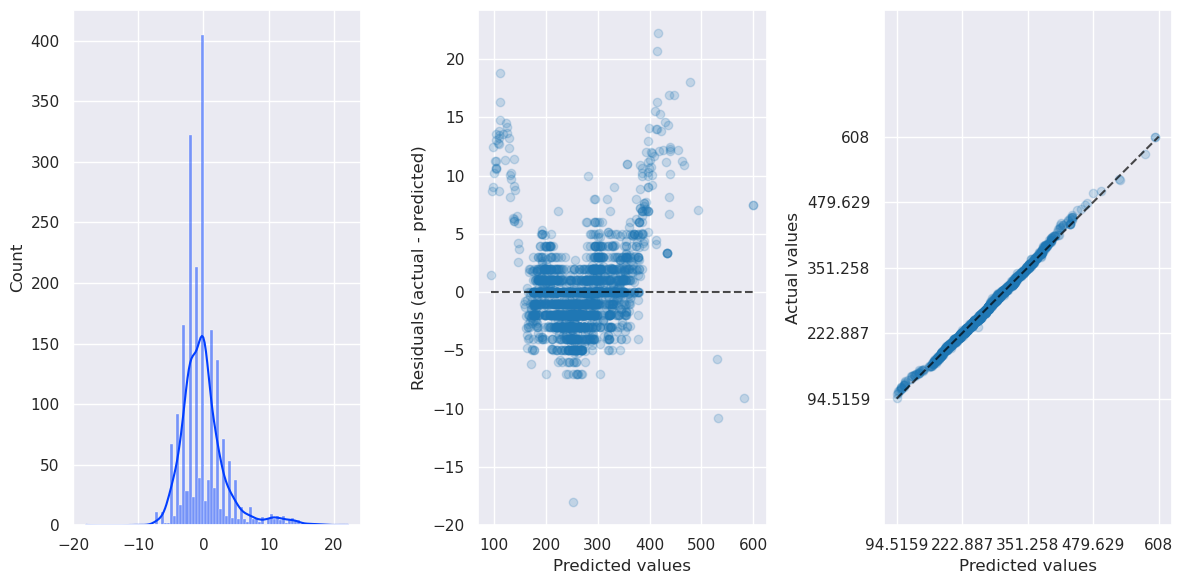

In [17]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.1, eng_formatter=True)

In [18]:
dump(grid_search.best_estimator_, MODELO_FINAL)

['/home/everson/Downloads/Ciência de Dados Impressionador/24 - Projeto - Emissão de CO2/modelos/ridge.joblib']